# Investigating Fandango Movie Ratings
In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/).

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:
- The actual rating was almost always rounded __up__ to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data __with the goal to determine whether there has been any change in Fandango's rating system after Hickey's analysis__.

## Introduction
For our analysis we will be using:
- [this data set](https://github.com/fivethirtyeight/data/tree/master/fandango), that Walt Hickey collected to analyze the characteristics of Fandango's rating system previous to his analysis and made public.
- [and this data set](https://github.com/mircealex/Movie_ratings_2016_17), which contains collected movie ratings data for movies released in 2016 and 2017, which we'll use to analyze the rating system's characteristics after Hickey's analysis.

Let's import relevant packages as well as these data sets to start exploring the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

before = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

In [2]:
before.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


Let's isolate the columns specifically related to Fandango's ratings: 
- For Hickey's data set (`before`), we'll isolate: `FILM`, `Fandango_Stars`, `Fandango_Ratingvalue`, `Fandango_votes`, `Fandango_Difference`.
- For the other data set (`after`), we'll isolate: `movie`, `year`, `fandango`.

In [4]:
fandango_before = before[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
fandango_after = after[['movie', 'year', 'fandango']].copy()

__The population of interest is made up of all movie ratings at Fandango, no matter when they were posted.__

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time - before and after Hickey's analysis - to then compare the two.

This is fulfilled by our imported data as one was sampled before Hickey's analysis and one after. We need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From the `read.me` file in the guthub repository containing the data used by Hickey we can read that the following sampling criteria was used:
- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

Thus, the sampling is clearly not random as all movies did not make the cut and on can wonder whether or not this sample is actually representative of the entire population. It seems likely it isn't fully representative as there can be temporal trends affecting the sample, such as movies in 2015 performing extrodinarily well or poor.

From the `read.me` file in the guthub repository containing the data from 2016 and 2017 we can read that the following sampling criteria was used:
- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

The authors sampling method is called purposive sampling. They sampled it in a certain way with a specific research question in mind, and they don't seem too useful for us.

## Altering our goal
At this point we can either try to gather new data or define a new goal to pursue, that more likely can be answered with our available data. As it's very challenging (maybe impossible) to gather the Fandango data from before Hickey's analysis again, we'll choose to do the latter and define a new goal.

We want to alter our goal in such as way that:
- The population of interest changes and the samples we currently work with become representative.
- The new goal is still a fairly good proxy for our initial goal, which was to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

__Our new goal is to find out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.__

With the new goal, we now have two populations that we want to describe and compare with each other:
- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

## Exploring the data sets
Before beginning our analysis there are some relevant questionmarks we need to straighten out.

Do both data sets contain popular movies (over 30 ratings)? If yes, are all or most entries popular?
Information about the number of ratings is present in `fandango_before`, so we'll print the minimum to see if it meets the criteria:

In [5]:
fandango_before['Fandango_votes'].min()

35

35 is the lowest. Hence, all movies in `fandango_before` can be considered popular.

We don't have the corresponding data in `fandango_after` and need to complement with some from information elsewhere.
An approach to be able to say with a reasonable certainty that most movies in `fandango_after` are popular we'll make a random sample and look up the number of ratings to the corresponding movies as of today.

In [6]:
fandango_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


The following number of ratings was found in 2020:

| Movie | Number of ratings |
|---|---|
| Mechanic: Resurrection | 2247 |
| Warcraft | 7271 |
| Max Steel | 493 |
| Me Before You | 5263 |
| Fantastic Beasts and Where to Find Them | 13400 |
| Cell | 17 |
| Genius | 127 |
| Sully | 11877 |
| A Hologram for the King | 500 |
| Captain America: Civil War | 35057 |

Only one movie had less than 30 ratings, that is, 90% of this sample are popular. Most "very popular". Let's consider this enough to continue with more confidence.

We also want to make sure that we only include movies from 2015 respectively 2016. In `fandango_after` we have a `year`-column very useful for this purpose. In `fandango_before` the year is included at the end of each movie title, in the `FILM`-column. We'll need to isolate the year in a new column before we proceed.

In [7]:
pattern = r'\((\d{4})\)$'
fandango_before['year'] = fandango_before['FILM'].str.extract(pattern)
fandango_before['year'] = fandango_before['year'].astype(int)
fandango_before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


Let's now remove any potential entires belonging to other years that 2015 respectively 2016 from the respective data sets:

In [8]:
print(fandango_before['year'].value_counts(dropna=False), '\n')
print(fandango_after['year'].value_counts(dropna=False))

2015    129
2014     17
Name: year, dtype: int64 

2016    191
2017     23
Name: year, dtype: int64


In [9]:
fandango_before = fandango_before[fandango_before['year'] == 2015]
fandango_after = fandango_after[fandango_after['year'] == 2016]

In [10]:
print(fandango_before['year'].value_counts(dropna=False), '\n')
print(fandango_after['year'].value_counts(dropna=False))

2015    129
Name: year, dtype: int64 

2016    191
Name: year, dtype: int64


With that done, we are now ready to begin actually analysing the data sets.

## Comparing distributions
Remember, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. With our data sets decently representative, let's now begin comparing the data sets.

We'll create one kernal density plot for each data set:

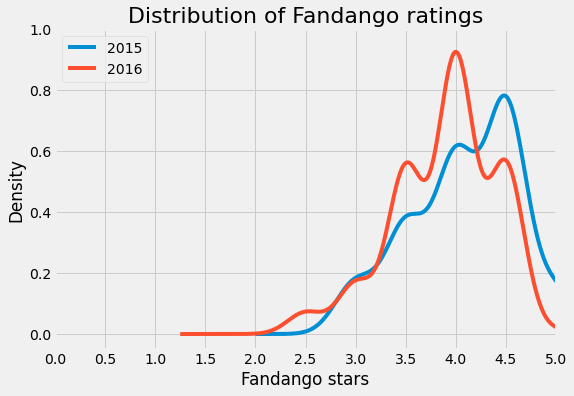

In [11]:
plt.style.use('fivethirtyeight')
fandango_before['Fandango_Stars'].plot.kde(label = '2015', figsize = (8,5.5))
fandango_after['fandango'].plot.kde(label = '2016')
plt.title('Distribution of Fandango ratings', size = '22')
plt.xlabel('Fandango stars')
plt.legend()
plt.xlim(0,5)
plt.ylim(-0.05,1)
plt.xticks(np.arange(0,5.1,0.5))
plt.show()

A few observations can be made:
- Both the 2015 and 2016 distributions are heavily left skewed.
- There seem to be a shift to the left for the 2016 data compared to 2015. The very high ratings of 4.5 and 5.0 are substantially more common in 2015.

The left skew indicates that movies at Fandango generally receive high ratings. As Fandango also sells movie tickets and higher displayed movie ratings may result in a higher probability of purchase since it means the value the customer expects to receive is higher. This means Fandango may be incentivised to display higher ratings. It'd be really interesting to investigate this further.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

## Comparing relative frequencies

While comparing the distributions with the help of the kernel density plots was a great start, we now need to analyze more granular information.

We determined earlier that the data sets have a differing number of entries. Therefore, it doesn't really make sense to compare absolut frequencies between the two. Relative is for sure to prefer. Let's compute the two relative frequency tables and convert to percentages for increased readability. 

In [12]:
before_freq = fandango_before['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100
after_freq = fandango_after['fandango'].value_counts(normalize = True).sort_index() * 100
print('2015:')
print(before_freq, '\n')
print('2016:')
print(after_freq)

2015:
3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64 

2016:
2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64


Let's merge the two together to examine them side by side.

In [13]:
before_freq = before_freq.append(pd.Series([0], index = [2.5]))
merged_freq = pd.concat([before_freq, after_freq], axis=1)
merged_freq.columns = ['2015', '2016']
merged_freq

,2015,2016
2.5,0.000000,3.141361
3.0,8.527132,7.329843
3.5,17.829457,24.083770
4.0,28.682171,40.314136
4.5,37.984496,24.607330
5.0,6.976744,0.523560


This dataframe tells a similar tale to that of the KDE plots above. It does however also convey som specifics:
- 6.97% of 2015 entries have 5.0 rating, which is vastly different from the 0.52% of 2016. Looking at 4.5 rating, we have 37.98% for 2015 and 24.61% for 2016, also a significant difference.
- 2015 has no entries rated below 3.0, in contrast to 2016 that has 3.14% of entries rated 2.5.
- For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

## Determining the direction of change

We confirmed with the two tables before that there is indeed a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots.

Let's take a couple of summary metrics to get a more precise picture about the direction of the change. In what follows, we'll compute the mean, the median, and the mode for both distributions and then use a bar graph to plot the values.

In [14]:
mean_15 = fandango_before['Fandango_Stars'].mean()
mean_16 = fandango_after['fandango'].mean()

median_15 = fandango_before['Fandango_Stars'].median()
median_16 = fandango_after['fandango'].median()

mode_15 = fandango_before['Fandango_Stars'].mode()[0]
mode_16 = fandango_after['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_15, median_15, mode_15]
summary['2016'] = [mean_16, median_16, mode_16]
summary.index = ['mean', 'median', 'mode']
summary.round(2)

,2015,2016
mean,4.09,3.89
median,4.00,4.00
mode,4.50,4.00


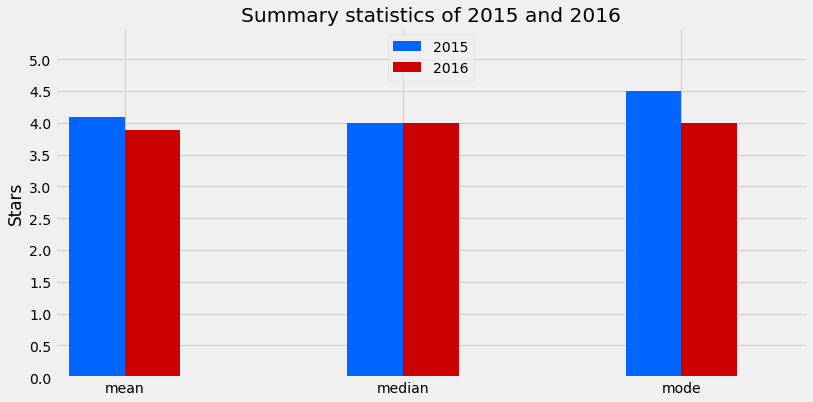

In [15]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'edge', label = '2015', width = -.2)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .2,
                         rot = 0, figsize = (12,6))

plt.title('Summary statistics of 2015 and 2016')
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(loc = 'upper center')
plt.show()

The mean rating was higher in 2015 with approximately 0.2. This means a drop of almost 5% in 2016 relative to 2015:

In [16]:
round((summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0], 3)

0.048

The median is the same for both distributions but the mode in 2015 is 0.5 higher. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

## Conclusion
Our analysis determined that there seems to be a difference in rating at Fandongo between movies released in 2015 compared to 2016. Movies from 2015 tend to be rated higher than those from 2016.

This answers our adjusted goal, and could act as somewhat of a proxy for our first goal. That is, it is likely ratings were slightly higher before Hickey's analysis compared to after. The cause of this is unknown but it does make commercial sense for Fandango to secretly attempt to boost their ratings, as discussed earlier.